In [35]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.stats as stats
import copy
pd.set_option("mode.chained_assignment", None)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")

# Uciml repo
from ucimlrepo import fetch_ucirepo

# Pytorch device specific configuration
# Pytorch Gpu Configuration for cuda
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for dml devices
import torch_directml

device = torch_directml.device()

# Set default devices
torch.set_default_device(device)

In [37]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")

# z-score all columns
data = (data - data.mean()) / data.std(ddof=1)

# save a copy of the data (because we'll replace some values with nan's below)
dataOrig = copy.deepcopy(data)

In [38]:
# number of data points to set missing
n2nan = 10

# pick n random rows to set to nan
# (note: in the video I don't have replace=False, which means it's possible to select the same values twice)
whichVals2nan = np.random.choice(range(len(data)), size=n2nan, replace=False)

# set those values to be nan (safe to ignore the overwrite warning)
data["residual sugar"][whichVals2nan] = np.nan

# for splitting the data, it will be helpful to have a vector of all real-valued rows
whichValsNotNan = np.where(~data["residual sugar"].isna())[0]

# confirm
print(np.sort(whichVals2nan))
print(np.where(data["residual sugar"].isna())[0])

[  38  518  555  655  874  949 1009 1057 1201 1312]
[  38  518  555  655  874  949 1009 1057 1201 1312]


/tmp/ipykernel_11697/368313612.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data["residual sugar"][whichVals2nan] = np.nan


In [40]:
# convert from pandas dataframe to tensor

# vector with residual sugar dropped, for training data
cols2keep = data.keys()
cols2keep = cols2keep.drop("residual sugar")

# extract dataframe to TRAIN tensors
train_dataT = torch.tensor(data[cols2keep].values).float()
train_dataT = train_dataT[whichValsNotNan, :]
train_labelT = torch.tensor(data["residual sugar"].values).float()
train_labelT = train_labelT[whichValsNotNan, None]  # the 'None' is transform to matrix


# same for TEST tensors
test_dataT = torch.tensor(dataOrig[cols2keep].values).float()
test_dataT = test_dataT[whichVals2nan, :]
test_labelT = torch.tensor(dataOrig["residual sugar"].values).float()
test_labelT = test_labelT[whichVals2nan, None]  # the 'None' is transform to matrix

# confirm sizes
print(f"Original data: {data.shape}\n")
print(f"   Train data: {train_dataT.shape}\n")
print(f" Train labels: {train_labelT.shape}\n")
print(f"    Test data: {test_dataT.shape}\n")
print(f"  Test labels: {test_labelT.shape}")

Original data: (1599, 12)

   Train data: torch.Size([1579, 11])

 Train labels: torch.Size([1579, 1])

    Test data: torch.Size([10, 11])

  Test labels: torch.Size([10, 1])


In [44]:
# then convert them into PyTorch Dataset
train_dataDataset = TensorDataset(train_dataT, train_labelT)

# finally, translate into dataloader objects
batchsize = 32
train_data = DataLoader(
    train_dataDataset, batch_size=batchsize, shuffle=True, drop_last=True
)

# note: we don't need a TEST dataloader; we'll just pass along the test tensor after training

In [45]:
def createTheModel():
    class WineQualityModel(nn.Module):
        def __init__(self):
            super().__init__()
            # Input Layer
            self.input = nn.Linear(11, 64)
            # Hidden Layers
            self.hidden1 = nn.Linear(64, 128)
            self.hidden2 = nn.Linear(128, 16)
            # Output Layers
            self.output = nn.Linear(16, 1)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            return self.output(x)

    net = WineQualityModel()

    # Loss Function
    lossFun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, lossFun, optimizer

In [6]:
# Test the model
net, lossFun, optimizer = createTheModel()
tempData = torch.tensor(np.random.randn(100, 11)).float()
print(net(tempData))

tensor([[-0.1884],
        [-0.2130],
        [-0.2063],
        [-0.2050],
        [-0.1902],
        [-0.1810],
        [-0.2069],
        [-0.2100],
        [-0.1847],
        [-0.1947],
        [-0.2149],
        [-0.1975],
        [-0.1882],
        [-0.2105],
        [-0.2143],
        [-0.2036],
        [-0.2005],
        [-0.1911],
        [-0.2048],
        [-0.1803],
        [-0.1905],
        [-0.1913],
        [-0.2034],
        [-0.2073],
        [-0.2157],
        [-0.1948],
        [-0.2033],
        [-0.1982],
        [-0.1972],
        [-0.2021],
        [-0.2154],
        [-0.2032],
        [-0.2088],
        [-0.2016],
        [-0.1925],
        [-0.1859],
        [-0.1884],
        [-0.2221],
        [-0.2174],
        [-0.2164],
        [-0.1913],
        [-0.1912],
        [-0.1946],
        [-0.2060],
        [-0.1784],
        [-0.2068],
        [-0.1974],
        [-0.2495],
        [-0.1925],
        [-0.1684],
        [-0.2194],
        [-0.2018],
        [-0.

In [46]:
def trainTheModel(nEpochs):
    # Initialize variables
    trainAcc = np.zeros(nEpochs)
    losses = np.zeros(nEpochs)

    # The loop
    for epoch in range(nEpochs):
        print(f'Training epoch: {epoch}')
        # Model training mode
        net.train()

        # Batch loss and accuracy initialization
        batchLoss = []
        batchAcc = []

        # The batch loop
        for X, y in train_data:

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss and accuracy
            batchLoss.append(loss.cpu().item())
            batchAcc.append(
                (100 * torch.mean((torch.abs(yHat - y) < 1).float())).cpu()
            )

        # Batch loop end

        # Train Acc
        trainAcc[epoch] = np.mean(batchAcc)
        losses[epoch] = np.mean(batchLoss)

    # The Loop End

    return trainAcc, losses

In [52]:
# Model Instance
net, lossFun, optimizer = createTheModel()

# Model Training
nEpochs = 300
trainAcc, losses = trainTheModel(nEpochs)

Training epoch: 0
Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10
Training epoch: 11
Training epoch: 12
Training epoch: 13
Training epoch: 14
Training epoch: 15
Training epoch: 16
Training epoch: 17
Training epoch: 18
Training epoch: 19
Training epoch: 20
Training epoch: 21
Training epoch: 22
Training epoch: 23
Training epoch: 24
Training epoch: 25
Training epoch: 26
Training epoch: 27
Training epoch: 28
Training epoch: 29
Training epoch: 30
Training epoch: 31
Training epoch: 32
Training epoch: 33
Training epoch: 34
Training epoch: 35
Training epoch: 36
Training epoch: 37
Training epoch: 38
Training epoch: 39
Training epoch: 40
Training epoch: 41
Training epoch: 42
Training epoch: 43
Training epoch: 44
Training epoch: 45
Training epoch: 46
Training epoch: 47
Training epoch: 48
Training epoch: 49
Training epoch: 50
Training epoch: 51
Training epoch: 52
Tra

In [56]:
# get the predictions for the missing data
yHatTrain = net(train_dataT)
yHatTest = net(test_dataT)

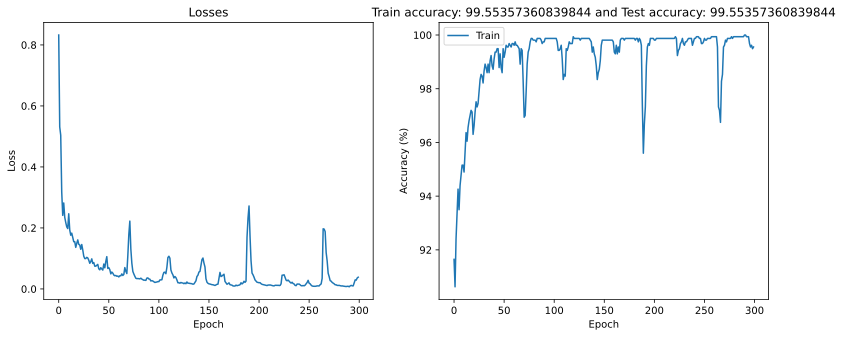

In [57]:
# Plot the result
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].plot(losses)
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epoch")
ax[1].set_title(f"Train accuracy: {trainAcc[-1]} and Test accuracy: {trainAcc[-1]}")
ax[1].legend()
plt.show()

plt.show()

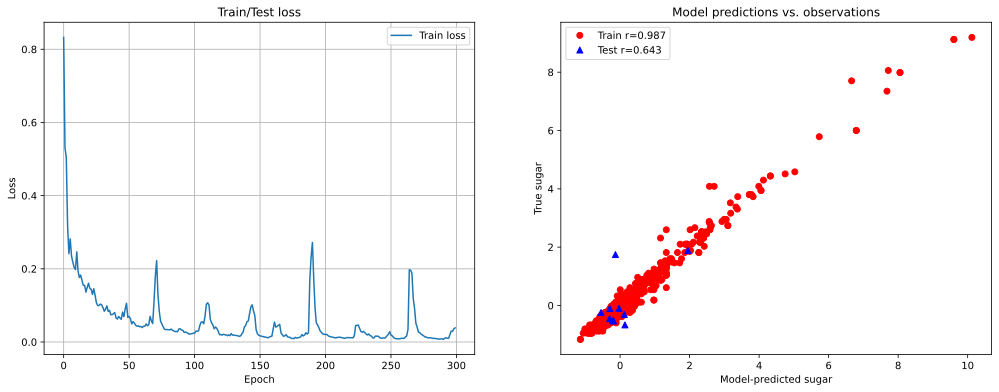

In [58]:
# plot some results
fig, ax = plt.subplots(1, 2, figsize=(17, 6))

ax[0].plot(losses, label="Train loss")
ax[0].set_title("Train/Test loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid()


ax[1].plot(yHatTrain.cpu().detach(), train_labelT.cpu(), "ro")
ax[1].plot(yHatTest.cpu().detach(), test_labelT.cpu(), "b^")
ax[1].set_xlabel("Model-predicted sugar")
ax[1].set_ylabel("True sugar")
ax[1].set_title("Model predictions vs. observations")

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.cpu().detach().T, train_labelT.cpu().T)[1, 0]
corrTest = np.corrcoef(yHatTest.cpu().detach().T, test_labelT.cpu().T)[1, 0]
ax[1].legend([f"Train r={corrTrain:.3f}", f"Test r={corrTest:.3f}"])

plt.show()